In [2]:
import numpy as np
import sklearn
import os
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from cnn import Net

%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
CLEANED_DIR = '/content/drive/MyDrive/'
# DATASET_PICKLE = [traces, images, tokens, expressions]
path = os.path.join(CLEANED_DIR, 'dataset_cleaned_125.pkl')

with open(path, 'rb') as f:
    dataset = pickle.load(f)
          
print((len(dataset), len(dataset[0])))

(4, 10939)


In [5]:
v = []
tokens = dataset[2]
for token in tokens:
    for item in token.split():
        v.append(item)
        
np.unique(v)
len(np.unique(v))

125

In [6]:
CLEANED_DIR = '/content/drive/MyDrive/'
path = os.path.join(CLEANED_DIR, 'dataset_cleaned_125.pkl')
with open(path, 'wb') as f:
    pickle.dump(dataset, f)
          
print('Saved pickled dataset at ', path)

Saved pickled dataset at  /content/drive/MyDrive/dataset_cleaned_125.pkl


In [7]:
images, tokens = dataset[1], dataset[2]

### Hold out

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, tokens, test_size=1/4)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

8204
8204
2735
2735


### KFold

In [9]:
# load vocabulary

with open('/content/drive/MyDrive/vocab.txt', 'r') as f:
    vocab = f.read().split('\n')
    
print(len(vocab))

126


### Visualize target lengths (i.e. how many tokens is one expression?)

482
7271


Text(0.5, 0, 'token length')

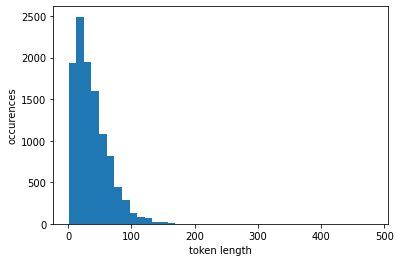

In [10]:
L = []

for tok in tokens:
    L.append(len(tok))
    
print(np.max(L))
print(np.argmax(L))
plt.hist(L, bins=40)
plt.ylabel('occurences')
plt.xlabel('token length')

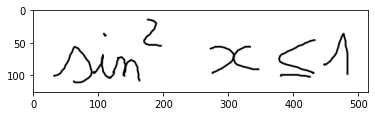

In [11]:
plt.imshow(images[7278], cmap='gray')

### Cutoff tokens longer than length 150

Like mentioned in the paper (A Visual Latex Decompiler), we remove training samples with tokens longer than 150. However, we leave them in for testing.

We would thus remove 23 samples from the training set.

In [12]:
L = np.array(L)

(L>150).sum()
((L>150).sum()) / len(L)

0.0021025687905658653

In [13]:
def cutoff(X, y, token_length):
    '''Remove samples from X an y where y has a token length > 150.'''
    removed = []
    for idx in reversed(range(len(y))):
        if len(y[idx]) > token_length:
            print(idx)
            removed.append((X[idx], y[idx]))
    return removed
                           
rem = cutoff(X_train, y_train, token_length=150)

8157
6805
6783
6012
5934
5417
4858
4575
4309
3959
3582
2885
970


## Dataset object

In [14]:
# load encoder
DATA = '/content/drive/MyDrive/'

vocab = np.load(DATA + 'labelencoding.npy')
vocab

array(['!', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '<', '=', '>', 'A', 'B', 'C', 'E',
       'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'V',
       'X', 'Y', '[', '\\', '\\!', '\\;', '\\Big', '\\Bigg', '\\Delta',
       '\\alpha', '\\beta', '\\cdot', '\\cdots', '\\cos', '\\div',
       '\\exists', '\\forall', '\\frac', '\\gamma', '\\geq', '\\gt',
       '\\hbox', '\\in', '\\infty', '\\int', '\\lambda', '\\lbrack',
       '\\ldots', '\\left', '\\leq', '\\lim', '\\limits', '\\log', '\\lt',
       '\\mathrm', '\\mbox', '\\mu', '\\neq', '\\parallel', '\\phi',
       '\\pi', '\\pm', '\\prime', '\\rbrack', '\\right', '\\rightarrow',
       '\\sigma', '\\sin', '\\sqrt', '\\sum', '\\tan', '\\theta',
       '\\times', '\\{', '\\}', ']', '^', '_', 'a', 'b', 'c', 'd', 'e',
       'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
       's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}'],
      dtype='<U11

In [15]:
from encode import train_label_encoding, OneHotEncoder

label_enc = train_label_encoding(vocab)

In [16]:
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import PIL

input_shape=(250, 490)

transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_shape),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
            transforms.ToTensor(), # This also normalizes the image
        ])

target_transform = OneHotEncoder(label_enc)

class ImgTokenDataset(Dataset):
    def __init__(self, images, tokens, transform=transform, target_transform=target_transform, vocab=vocab):
        self.images = images
        self.tokens = tokens
        self.transform = transform
        self.target_transform = target_transform
        self.vocab = vocab

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.tokens[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target
    
    
train_data = ImgTokenDataset(X_train, y_train, transform=transform, target_transform=target_transform, vocab=vocab)
    
test_data = ImgTokenDataset(X_test, y_test, transform=transform, target_transform=target_transform, vocab=vocab)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1293: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


In [17]:
trainloader = DataLoader(train_data, batch_size=28, shuffle=True)
testloader = DataLoader(test_data, batch_size=28, shuffle=True)

## CNN Model

In [18]:
from cnn import Net

import torch.optim as optim
print('loading...')
net = Net(input_shape, vocab)

criterion = nn.BCELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if we set the hardware to GPU in the Notebook settings, this should print a CUDA device:
# device = 'cpu'

print(device)

net.to(device)

loading...
cuda:0


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=115200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=126, bias=True)
)

In [19]:
def report_precision_recall(net, data, device, threshold=0.5):
      
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)

    P, R = [], []
    
    for sample in range(len(outputs.cpu())):
        pred_pos = set(np.where(outputs[sample].cpu()>=threshold)[0])
        pred_neg = set(np.where(outputs[sample].cpu()<threshold)[0])
        actual_pos = set(np.where(labels[sample].cpu()==1)[0])
        actual_neg = set(np.where(labels[sample].cpu()==0)[0])
        if len(actual_pos) < 1:
            continue
        TP = len(pred_pos & actual_pos)
        FP = len(pred_pos & actual_neg)
        TN = len(pred_neg & actual_neg)
        FN = len(pred_neg & actual_pos)
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        P.append(precision)
        R.append(recall)

    P, R = np.array(P), np.array(R)
    return [P.mean(), P.std(), R.mean(), R.std()]

In [20]:
log_every_n_batch = 1
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    print('start')
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()   # zero the gradient buffers
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        print('         \n')
        if i % log_every_n_batch == 0:
            print('Batch: {}   Training loss: {}'.format(i, loss.item()))
            try:
              p_m, p_s, r_m, r_s = report_precision_recall(net, data, device)
            except:
              print("Positive samples missing, skipping")
              continue
            print(f'Precision: {100*p_m:.2f} +/- {100*p_s:.1f} %')
            print(f'Recall: {100*r_m:.2f} +/- {100*r_s:.1f} %')

print('Finished Training')

start


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Streaming output truncated to the last 5000 lines.
Positive samples missing, skipping
         

Batch: 234   Training loss: 0.1542280912399292
Positive samples missing, skipping
         

Batch: 235   Training loss: 0.16635552048683167
Positive samples missing, skipping
         

Batch: 236   Training loss: 0.15841761231422424
Positive samples missing, skipping
         

Batch: 237   Training loss: 0.18384364247322083
Positive samples missing, skipping
         

Batch: 238   Training loss: 0.17102347314357758
Positive samples missing, skipping
         

Batch: 239   Training loss: 0.13412904739379883
Positive samples missing, skipping
         

Batch: 240   Training loss: 0.1713649183511734
Positive samples missing, skipping
         

Batch: 241   Training loss: 0.16670289635658264
Positive samples missing, skipping
         

Batch: 242   Training loss: 0.15532030165195465
Positive samples missing, skipping
         

Batch: 243   Training loss: 0.1572514921426773
Positive sam

In [21]:
def test_cnn(net, testLoader, threshold=0.1):
    correct = []
    total = []
    
    with torch.no_grad():
        for idx, data in enumerate(testLoader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            
            for sample in range(len(outputs.cpu())):
                inputs, labels = data[0].to(device), data[1].to(device)
                preds = np.where(outputs[sample].cpu()>threshold)[0]
                labels_ = np.where(labels[sample].cpu()==1)[0]
                # print(len(preds), len(outputs))
                if len(labels_) < 1:
                    continue
                intersection = set(preds) & set(labels_)
                total.append(len(labels_))
                correct.append(len(intersection))
            try:
              report_precision_recall(net, data, device)
            except:
              print("No prediction as postive, skipping..")
              continue
        return np.array(correct), np.array(total)

In [22]:
correct, total = test_cnn(net, testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
No prediction as postive, skipping..
N

In [23]:
len(correct)

2734

In [24]:
acc = correct / total

print(acc.std())
print(acc.mean())

0.23686504987980564
0.6492449626549716


# Cross validation with 5 folds

In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)
cv.get_n_splits(images, tokens)

ACC = []
HIST = []

BS = 28
log_every_n_batch=1

data = ImgTokenDataset(images, tokens, transform=transform, target_transform=target_transform, vocab=vocab)
for fold, (train_index, test_index) in enumerate(cv.split(images)):
    
    HIST.append([])
    
    print('Fold: ', fold)
    # Setup data

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_index)

    trainloader = torch.utils.data.DataLoader(
                      data, 
                      batch_size=BS, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      data,
                      batch_size=BS, sampler=test_subsampler)

    # Model
    net = Net(input_shape, vocab)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.to(device)
    # Train
    for epoch in range(10):  # loop over the dataset multiple times
        print('Epoch: ', epoch)
        for i, d in enumerate(trainloader, 0):
            inputs, labels = d
        
            inputs, labels = inputs.to(device), labels.to(device)
            #inputs = inputs.cuda()
            #labels = labels.cuda()
            optimizer.zero_grad()   # zero the gradient buffers
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
                HIST[fold].append(loss.item())

            if i % log_every_n_batch == 0:
              print('Batch: {}   Training loss: {}'.format(i, loss.item()))
              p_m, p_s, r_m, r_s = report_precision_recall(net, d, device)
              print(f'Precision: {100*p_m:.2f} +/- {100*p_s:.1f} %')
              print(f'Recall: {100*r_m:.2f} +/- {100*r_s:.1f} %')
            
                
    correct, total = test_cnn(net, testloader)
    acc = correct / total

    print('Accuracy: ')
    print(f'{acc.mean():.3f} +/- {(acc.std()/2):.2f}')
    print()
    ACC.append(acc)
    
                      
print('Finished Training')

Fold:  0
Epoch:  0
Batch: 0   Training loss: 0.6959236860275269
Precision: 5.76 +/- 3.0 %
Recall: 47.17 +/- 21.9 %


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Streaming output truncated to the last 5000 lines.
Recall: 14.30 +/- 12.2 %
Batch: 157   Training loss: 0.16844569146633148
Precision: 57.14 +/- 49.5 %
Recall: 14.72 +/- 15.2 %
Batch: 158   Training loss: 0.173855260014534
Precision: 75.00 +/- 43.3 %
Recall: 19.24 +/- 14.7 %
Batch: 159   Training loss: 0.17860834300518036
Precision: 53.57 +/- 49.9 %
Recall: 11.58 +/- 12.0 %
Batch: 160   Training loss: 0.1828005313873291
Precision: 67.86 +/- 46.7 %
Recall: 16.34 +/- 13.6 %
Batch: 161   Training loss: 0.18421098589897156
Precision: 60.71 +/- 48.8 %
Recall: 15.56 +/- 13.7 %
Batch: 162   Training loss: 0.1691499799489975
Precision: 53.57 +/- 49.9 %
Recall: 14.16 +/- 15.8 %
Batch: 163   Training loss: 0.1699882447719574
Precision: 71.43 +/- 45.2 %
Recall: 18.97 +/- 15.7 %
Batch: 164   Training loss: 0.18881064653396606
Precision: 64.29 +/- 47.9 %
Recall: 15.90 +/- 13.6 %
Batch: 165   Training loss: 0.18822944164276123
Precision: 64.29 +/- 47.9 %
Recall: 15.16 +/- 15.2 %
Batch: 166   Trainin

KeyboardInterrupt: ignored

In [25]:
mean_accs = []
for vals in ACC:
    mean_accs.append(np.mean(vals))

print(np.mean(mean_accs))
print(np.std(mean_accs))

NameError: ignored

IndexError: ignored

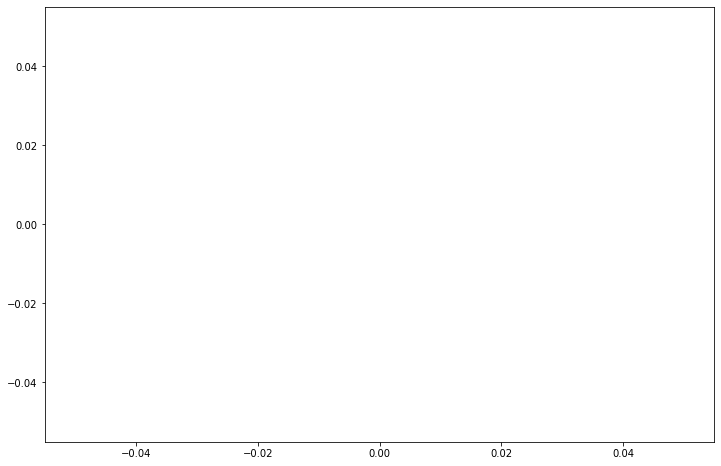

In [ ]:
plt.figure(figsize=(12,8))

for fold in range(5):
    plt.plot(list(range(len(HIST[fold]))), HIST[fold], label=f'fold {fold}', alpha=0.5)
    
# plt.xticks(labels=str(50*np.arange(len(HIST[fold]))))
plt.xlabel('iterations * 50')
plt.ylabel('training loss')
plt.legend()
plt.grid()

# StratifiedShuffleSplit with 10 folds

 Experimenting with StratifiedShuffleSplit since this will make sure that during training, a percentage of samples for each class is preserved, so better training for each data labels.

In [26]:
d = {}
for token in tokens:
  d[token] = d.get(token, 0) + 1

In [27]:
sufficient_data_available = []
for key in d:
  if d[key] > 1:
    sufficient_data_available.append(key)

In [28]:
tokens_filtered = []
images_filtered = []
for idx in range(len(tokens)):
  token = tokens[idx]
  image = images[idx]
  if token in sufficient_data_available:
    tokens_filtered.append(token)
    images_filtered.append(image)

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3)
cv.get_n_splits(images_filtered, tokens_filtered)

ACC = []
HIST = []

BS = 28
log_every_n_batch=1

data = ImgTokenDataset(images_filtered, tokens_filtered, transform=transform, target_transform=target_transform, vocab=vocab)
for fold, (train_index, test_index) in enumerate(cv.split(images_filtered, tokens_filtered)):
    
    HIST.append([])
    
    print('Fold: ', fold)
    # Setup data

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_index)

    trainloader = torch.utils.data.DataLoader(
                      data, 
                      batch_size=BS, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      data,
                      batch_size=BS, sampler=test_subsampler)

    # Model
    net = Net(input_shape, vocab)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.to(device)
    # Train
    for epoch in range(10):  # loop over the dataset multiple times
        print('Epoch: ', epoch)
        for i, d in enumerate(trainloader, 0):
            inputs, labels = d
        
            inputs, labels = inputs.to(device), labels.to(device)
            #inputs = inputs.cuda()
            #labels = labels.cuda()
            optimizer.zero_grad()   # zero the gradient buffers
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
                HIST[fold].append(loss.item())

            if i % log_every_n_batch == 0:
              print('Batch: {}   Training loss: {}'.format(i, loss.item()))
              try:
                p_m, p_s, r_m, r_s = report_precision_recall(net, d, device)
              except:
                continue
              print(f'Precision: {100*p_m:.2f} +/- {100*p_s:.1f} %')
              print(f'Recall: {100*r_m:.2f} +/- {100*r_s:.1f} %')
            
                
    correct, total = test_cnn(net, testloader)
    acc = correct / total

    print('Accuracy: ')
    print(f'{acc.mean():.3f} +/- {(acc.std()/2):.2f}')
    print()
    ACC.append(acc)
    
                      
print('Finished Training')

Fold:  0
Epoch:  0
Batch: 0   Training loss: 0.6882122159004211


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Streaming output truncated to the last 5000 lines.
Precision: 66.55 +/- 34.2 %
Recall: 21.99 +/- 13.5 %
Batch: 68   Training loss: 0.18326899409294128
Precision: 69.05 +/- 34.4 %
Recall: 20.22 +/- 12.9 %
Batch: 69   Training loss: 0.16616378724575043
Precision: 50.00 +/- 35.8 %
Recall: 19.02 +/- 15.4 %
Batch: 70   Training loss: 0.17073678970336914
Precision: 64.88 +/- 30.1 %
Recall: 29.54 +/- 13.8 %
Batch: 71   Training loss: 0.1668853610754013
Precision: 50.89 +/- 38.9 %
Recall: 24.00 +/- 19.6 %
Batch: 72   Training loss: 0.174329474568367
Precision: 69.94 +/- 35.9 %
Recall: 24.27 +/- 13.7 %
Batch: 73   Training loss: 0.16692447662353516
Precision: 62.44 +/- 36.6 %
Recall: 24.07 +/- 16.0 %
Batch: 74   Training loss: 0.1948278546333313
Precision: 62.68 +/- 33.2 %
Recall: 22.17 +/- 12.9 %
Batch: 75   Training loss: 0.17241822183132172
Precision: 74.70 +/- 41.8 %
Recall: 24.64 +/- 17.2 %
Batch: 76   Training loss: 0.178675577044487
Precision: 65.00 +/- 36.9 %
Recall: 22.89 +/- 15.6 %
Ba

In [30]:
mean_accs = []
for vals in ACC:
    mean_accs.append(np.mean(vals))

print(np.mean(mean_accs))
print(np.std(mean_accs))

0.7352448281203714
0.018031604854437833


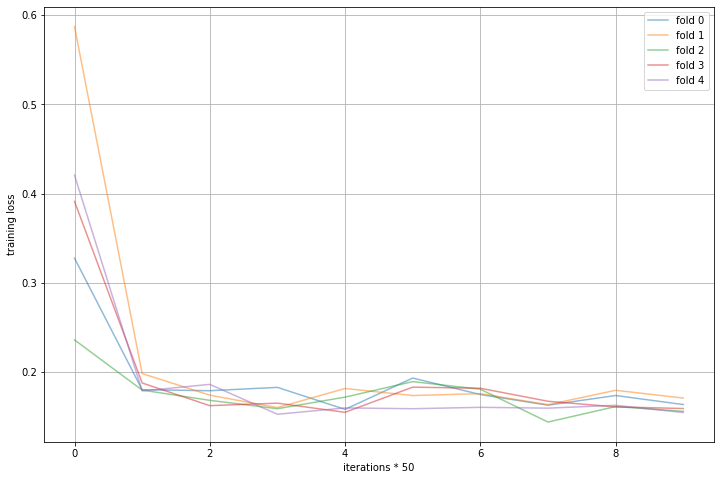

In [31]:
plt.figure(figsize=(12,8))

for fold in range(5):
    plt.plot(list(range(len(HIST[fold]))), HIST[fold], label=f'fold {fold}', alpha=0.5)
    
# plt.xticks(labels=str(50*np.arange(len(HIST[fold]))))
plt.xlabel('iterations * 50')
plt.ylabel('training loss')
plt.legend()
plt.grid()

# Experiment with different activation functions and pooling types

In [ ]:
trainloader = DataLoader(train_data, batch_size=28, shuffle=True)
testLoader = DataLoader(test_data, batch_size=28, shuffle=True)
threshold = 0.5
max_acc = float('-inf')

In [ ]:
with torch.no_grad():
  for activation_function in ['sigmoid', 'relu', 'tanh']:
      for pooling_type in ['max', 'avg']:
        net = Net(input_shape, vocab, activation_function=activation_function, pooling_type=pooling_type)
        net.to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        for epoch in range(10):  # loop over the dataset multiple times
          print('start')
          for i, data in enumerate(trainloader, 0):
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              optimizer.zero_grad()   # zero the gradient buffers
              outputs = net(inputs)
              loss = criterion(outputs, labels)
              loss.requires_grad = True
              loss.backward()
              optimizer.step()

        print('Finished Training')
        correct = []
        total = []
        for i, data in enumerate(testloader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = net(inputs)
        
          for sample in range(len(outputs.cpu())):
              preds = np.where(outputs[sample].cpu()>threshold)[0]
              labels_ = np.where(labels[sample].cpu()==1)[0]
              if len(labels_) < 1:
                  continue
              intersection = set(preds) & set(labels_)
              total.append(len(labels_))
              correct.append(len(intersection))
        correct, total = np.array(correct), np.array(total)
        acc = correct / total
        print("Activation Function: ", activation_function)
        print("Pooling type: ", pooling_type)
        max_acc = max(max_acc, acc.mean())
        print(acc.std())
        print(acc.mean())

start


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


start
start
start
start
start
start
start
start
start
Finished Training
Activation Function:  sigmoid
Pooling type:  max
0.181659119925223
0.47665325426424526
start
start
start
start
start
start
start
start
start
start
Finished Training
Activation Function:  sigmoid
Pooling type:  avg
0.1742652038501674
0.4519107982005662
start
start
start
start
start
start
start
start
start
start
Finished Training
Activation Function:  relu
Pooling type:  max
0.19316164602249752
0.39556651818846106
start
start
start
start
start
start
start
start
start
start
Finished Training
Activation Function:  relu
Pooling type:  avg
0.2004991317364644
0.5347273087022126
start


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


start
start
start
start
start
start
start
start
start
Finished Training
Activation Function:  tanh
Pooling type:  max
0.18924631471384631
0.49393252037589863
start
start
start
start
start
start
start
start
start
start
Finished Training
Activation Function:  tanh
Pooling type:  avg
0.1978202026539898
0.524757607075287
